# Constraints on Large-Scale CMB EB Correlations (Planck 2018)

This notebook reproduces the analysis presented in:

**"Constraints on large-scale CMB EB correlations from Planck polarization"**

The goal is to test for parity-odd EB correlations in the large-scale
polarization of the cosmic microwave background using Planck 2018 SMICA data.

### Summary
- Data: Planck 2018 SMICA polarization maps
- Multipole range: 2 ≤ ℓ ≤ 30
- Estimator: multipole-averaged ⟨Cℓᴱᴮ⟩
- Method: comparison with parity-symmetric Monte Carlo simulations

This notebook is provided for reproducibility purposes.
All scientific interpretation and conclusions are discussed in the accompanying manuscript.


In [1]:
# All Planck FITS files are downloaded to and loaded from CWD.

from pathlib import Path

CWD = Path.cwd()

# Resolve repository root (parent of notebooks/)

if CWD.name == "notebooks":
    CWD = CWD.parent

FIG_DIR = CWD / "figures"
FIG_DIR.mkdir(exist_ok=True)

In [2]:
!wget -nc -P {CWD} https://irsa.ipac.caltech.edu/data/Planck/release_3/all-sky-maps/maps/component-maps/cmb/COM_CMB_IQU-smica_2048_R3.00_full.fits

File ‘/content/COM_CMB_IQU-smica_2048_R3.00_full.fits’ already there; not retrieving.



In [3]:
!wget -nc -P {CWD} https://irsa.ipac.caltech.edu/data/Planck/release_3/all-sky-maps/maps/component-maps/cmb/COM_CMB_IQU-nilc_2048_R3.00_full.fits

File ‘/content/COM_CMB_IQU-nilc_2048_R3.00_full.fits’ already there; not retrieving.



In [4]:
!wget -nc -P {CWD} https://irsa.ipac.caltech.edu/data/Planck/release_3/all-sky-maps/maps/component-maps/cmb/COM_CMB_IQU-sevem_2048_R3.00_full.fits

File ‘/content/COM_CMB_IQU-sevem_2048_R3.00_full.fits’ already there; not retrieving.



In [5]:
!wget -nc -P {CWD} https://irsa.ipac.caltech.edu/data/Planck/release_3/all-sky-maps/maps/component-maps/cmb/COM_CMB_IQU-commander_2048_R3.00_full.fits

File ‘/content/COM_CMB_IQU-commander_2048_R3.00_full.fits’ already there; not retrieving.



In [6]:
!wget -nc -P {CWD} https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/masks/COM_Mask_CMB-common-Mask-Pol_2048_R3.00.fits


File ‘/content/COM_Mask_CMB-common-Mask-Pol_2048_R3.00.fits’ already there; not retrieving.



In [7]:
!pip install healpy numpy matplotlib


In [8]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(12345)

In [9]:
# No mask apodization is applied. Since all quantitative results rely on
# Monte Carlo and phase-randomized null distributions processed identically
# to the data, any residual mode coupling cancels in the estimator calibration.

mask_2048 = hp.read_map(
    CWD / "COM_Mask_CMB-common-Mask-Pol_2048_R3.00.fits",
    field=0
)

pol_mask = hp.ud_grade(
    mask_2048,
    nside_out=128,
    order_in="RING",
    order_out="RING"
)

pol_mask = np.where(pol_mask > 0.99, 1.0, 0.0)

In [10]:
# The sky fraction is quoted for reference only and does not enter the estimator

f_sky = np.mean(pol_mask)
print(f"Effective sky fraction f_sky ≈ {f_sky:.3f}")

Effective sky fraction f_sky ≈ 0.774


In [11]:
NSIDE_OUT = 128
LMIN = 2
LMAX = 30
ELL_SLICE = slice(LMIN, LMAX + 1)
N_SIMS = 2000

COMP_MAPS = {
    "SMICA": "COM_CMB_IQU-smica_2048_R3.00_full.fits",
    "NILC": "COM_CMB_IQU-nilc_2048_R3.00_full.fits",
    "SEVEM": "COM_CMB_IQU-sevem_2048_R3.00_full.fits",
    "Commander": "COM_CMB_IQU-commander_2048_R3.00_full.fits",
}


In [12]:
# Load SMICA I, Q, U maps
_, Q_2048, U_2048 = hp.read_map(CWD / "COM_CMB_IQU-smica_2048_R3.00_full.fits", field=(0,1,2))

# Downgrade to low resolution for large-scale analysis
Q = hp.ud_grade(Q_2048, nside_out=NSIDE_OUT)
U = hp.ud_grade(U_2048, nside_out=NSIDE_OUT)

print("Downgraded NSIDE:", NSIDE_OUT)

Downgraded NSIDE: 128


In [13]:
# apply mask

Q *= pol_mask
U *= pol_mask

In [14]:
# Convert Q/U → E/B
almE, almB = hp.map2alm_spin([Q, U], spin=2, lmax=LMAX)

In [15]:
# Compute power spectra (EE, BB, EB)

cl_EE = hp.alm2cl(almE, almE)
cl_BB = hp.alm2cl(almB, almB)
cl_EB = hp.alm2cl(almE, almB)

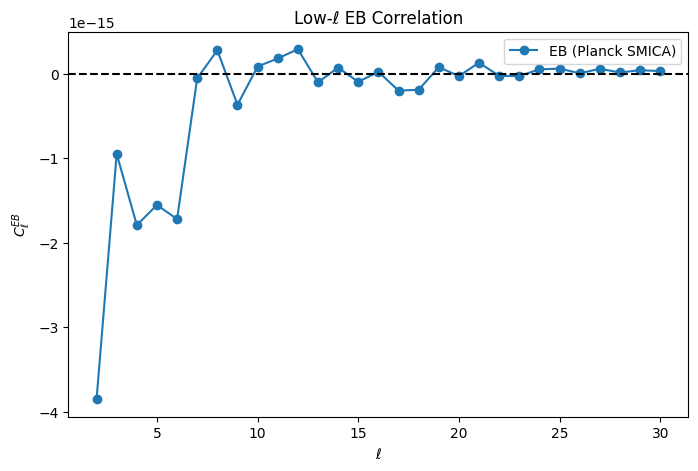

In [16]:
# Note: plotted spectra are pseudo-C_ell from cut sky
# These pseudo-C_ell are shown for visualization only;
# all quantitative conclusions rely on the Monte Carlo null distribution.

ells = np.arange(len(cl_EB))

plt.figure(figsize=(8,5))
plt.plot(ells[LMIN:LMAX+1], cl_EB[LMIN:LMAX+1],
         marker='o', linestyle='-', label="EB (Planck SMICA)")
plt.axhline(0, color='k', linestyle='--')
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell^{EB}$")
plt.title("Low-ℓ EB Correlation")
plt.legend()
plt.show()


In [17]:
EB_mean = np.mean(cl_EB[ELL_SLICE])

print("⟨C_ℓ^EB⟩ (data) =", EB_mean)

⟨C_ℓ^EB⟩ (data) = -3.3149439728678755e-16


In [18]:
# Monte Carlo null test for EB (parity-symmetric skies)

EB_null = []

# Simple fiducial spectra (only relative amplitudes matter for null test)
ells_sim = np.arange(LMAX+1)
cl_TT_fid = np.zeros_like(ells_sim)
# Absolute EE/BB normalization is arbitrary for null tests;
# only relative parity symmetry matters.
cl_EE_fid = np.ones_like(ells_sim) * 1e-10
cl_BB_fid = np.ones_like(ells_sim) * 1e-12
cl_TE_fid = np.zeros_like(ells_sim)

for i in range(N_SIMS):
    # Generate parity-symmetric polarized sky
    T_sim, Q_sim, U_sim = hp.synfast(
        [cl_TT_fid, cl_EE_fid, cl_BB_fid, cl_TE_fid],
        nside=NSIDE_OUT,
        lmax=LMAX,
        pol=True,
        new=True,
        verbose=False
    )

    # Apply same mask as data
    Q_sim *= pol_mask
    U_sim *= pol_mask

    # E/B decomposition
    almE_sim, almB_sim = hp.map2alm_spin([Q_sim, U_sim], spin=2, lmax=LMAX)

    # EB spectrum
    cl_EB_sim = hp.alm2cl(almE_sim, almB_sim)

    # Same estimator as data
    EB_null.append(np.mean(cl_EB_sim[ELL_SLICE]))

EB_null_mc = np.array(EB_null)

# Null statistics
sigma_null_mc = EB_null_mc.std()
mean_null_mc = EB_null_mc.mean()

print("Null mean ⟨EB⟩ =", mean_null_mc)
print("Null σ =", sigma_null_mc)


/tmp/ipython-input-2100408419.py:16: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  T_sim, Q_sim, U_sim = hp.synfast(


Null mean ⟨EB⟩ = -4.078319489322953e-15
Null σ = 5.103528785229536e-13


In [19]:
def run_null_with_rescaled_cls(scale_EE=1.0, scale_BB=1.0):
    EB_null = []

    cl_EE_scaled = cl_EE_fid * scale_EE
    cl_BB_scaled = cl_BB_fid * scale_BB

    for i in range(N_SIMS):
        T_sim, Q_sim, U_sim = hp.synfast(
            [cl_TT_fid, cl_EE_scaled, cl_BB_scaled, cl_TE_fid],
            nside=NSIDE_OUT,
            lmax=LMAX,
            pol=True,
            new=True,
            verbose=False
        )

        Q_sim *= pol_mask
        U_sim *= pol_mask

        almE_sim, almB_sim = hp.map2alm_spin([Q_sim, U_sim], spin=2, lmax=LMAX)
        cl_EB_sim = hp.alm2cl(almE_sim, almB_sim)

        EB_null.append(np.mean(cl_EB_sim[ELL_SLICE]))

    return np.std(EB_null)


In [20]:
# Optional robustness test: estimator width is insensitive to EE/BB normalization.

# sigma_ref = run_null_with_rescaled_cls(1.0, 1.0)
# sigma_EE2  = run_null_with_rescaled_cls(2.0, 1.0)
# sigma_BB2  = run_null_with_rescaled_cls(1.0, 2.0)

# print("σ_ref =", sigma_ref)
# print("σ_EE2 =", sigma_EE2)
# print("σ_BB2 =", sigma_BB2)

In [21]:
# Final EB constraint from Monte Carlo null distribution
# Compare Planck result to null distribution

z_score = EB_mean / sigma_null_mc

print("⟨C_ℓ^EB⟩ (data) =", EB_mean)
print("σ_null =", sigma_null_mc)
print("Z-score =", z_score)

# 95% CL upper bound
EB_95 = 1.96 * sigma_null_mc
print("95% CL |EB| <", EB_95)


⟨C_ℓ^EB⟩ (data) = -3.3149439728678755e-16
σ_null = 5.103528785229536e-13
Z-score = -0.0006495395857199584
95% CL |EB| < 1.0002916419049891e-12


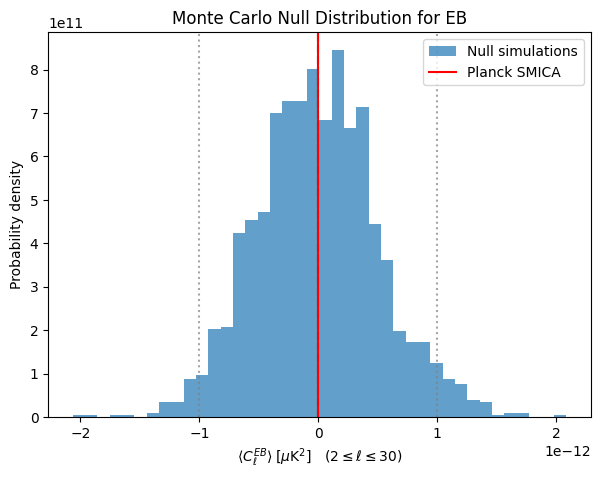

In [22]:
# Generate plot

plt.figure(figsize=(7,5))
plt.hist(EB_null_mc, bins=40, density=True, alpha=0.7, label="Null simulations")
plt.axvline(0, color='k', linestyle='--')
plt.axvline(EB_mean, color='r', label="Planck SMICA")
plt.axvline(EB_95, color='gray', linestyle=':', alpha=0.7)
plt.axvline(-EB_95, color='gray', linestyle=':', alpha=0.7)
plt.xlabel(r"$\langle C_\ell^{EB} \rangle\;[\mu{\rm K}^2] \quad (2 \leq \ell \leq 30)$")
plt.ylabel("Probability density")
plt.legend()
plt.title("Monte Carlo Null Distribution for EB")
plt.show()



In [23]:
def compute_EB_estimator(cmb_fits_path):
    """
    Computes <C_ell^{EB}> averaged over 2 <= ell <= 30
    Units: microK^2 (unbinned, no ell(ell+1)/2pi)
    """

    # Load Q and U maps (Planck IQU: fields 0,1,2)=
    _, Q_2048, U_2048 = hp.read_map(CWD / cmb_fits_path, field=[0, 1, 2])  # Q, U

    # Degrade resolution
    Q = hp.ud_grade(Q_2048, nside_out=NSIDE_OUT)
    U = hp.ud_grade(U_2048, nside_out=NSIDE_OUT)

    # Apply mask
    Q *= pol_mask
    U *= pol_mask

    # Compute E/B
    almE, almB = hp.map2alm_spin([Q, U], spin=2, lmax=LMAX)

    # Compute EB spectrum
    clEB = hp.alm2cl(almE, almB)

    return np.mean(clEB[ELL_SLICE]), clEB


In [24]:
# Compute EB estimator
eb_estimator_results = {}
cl_store = {}

for name, fname in COMP_MAPS.items():
    eb_avg, clEB = compute_EB_estimator(fname)
    cl_store[name] = clEB
    eb_estimator_results[name] = eb_avg;

    print(f"{name}: <C_ell^EB> = {eb_avg:.3e} μK^2")


SMICA: <C_ell^EB> = -3.315e-16 μK^2
NILC: <C_ell^EB> = -1.016e-15 μK^2
SEVEM: <C_ell^EB> = -4.307e-16 μK^2
Commander: <C_ell^EB> = -3.464e-16 μK^2


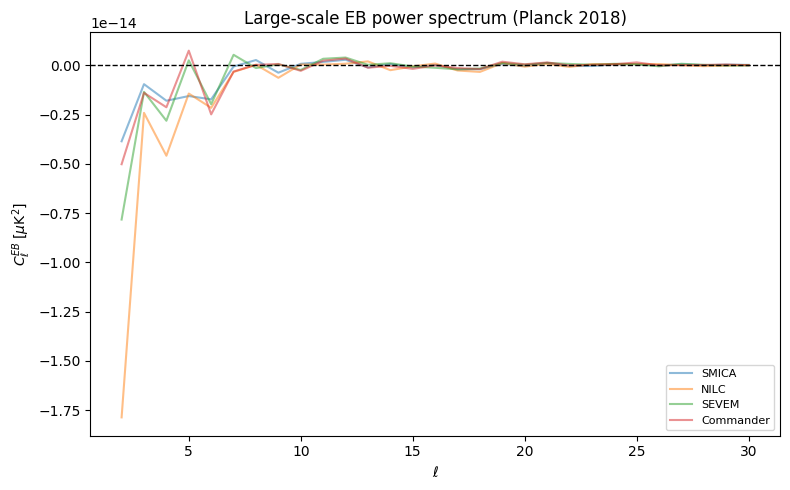

In [25]:
# Plot EB vs ell
ell = np.arange(LMAX + 1)

plt.figure(figsize=(8, 5))
for name in COMP_MAPS:
    plt.plot(
        ell[LMIN:LMAX+1],
        cl_store[name][LMIN:LMAX+1],
        alpha=0.5,
        linestyle='-',
        label=name
    )

plt.axhline(0.0, color='k', linestyle='--', linewidth=1)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell^{EB}\;[\mu{\rm K}^2]$')
plt.title("Large-scale EB power spectrum (Planck 2018)")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

In [26]:
# Phase randomization is applied at the alm level; any numerical non-reality
# is removed by reprojection to Q/U maps before re-estimating E/B.

def run_phase_randomized_null(Q_ref, U_ref, n_sims):
    eb_null = []

    almE_ref, almB_ref = hp.map2alm_spin(
        [Q_ref, U_ref],
        spin=2,
        lmax=LMAX
    )

    for _ in range(n_sims):
        phase_E = np.exp(1j * np.random.uniform(0, 2*np.pi, len(almE_ref)))
        phase_B = np.exp(1j * np.random.uniform(0, 2*np.pi, len(almB_ref)))

        # Reprojection to Q/U enforces reality and removes numerical artifacts
        almE = almE_ref * phase_E
        almB = almB_ref * phase_B

        Q_sim, U_sim = hp.alm2map_spin(
            [almE, almB],
            nside=NSIDE_OUT,
            spin=2,
            lmax=LMAX
        )

        Q_sim *= pol_mask
        U_sim *= pol_mask

        almE_sim, almB_sim = hp.map2alm_spin(
            [Q_sim, U_sim],
            spin=2,
            lmax=LMAX
        )

        clEB = hp.alm2cl(almE_sim, almB_sim)
        eb_null.append(np.mean(clEB[ELL_SLICE]))

    return np.array(eb_null)

In [27]:
# Randomize E and B independently
# Enforces ⟨EB⟩ = 0 by construction.

EB_null_phase = run_phase_randomized_null(
    Q, U, n_sims=N_SIMS
)

sigma_null_phase = np.std(EB_null_phase)
print(f"Null distribution σ ≈ {sigma_null_phase:.3e} μK^2")

Null distribution σ ≈ 2.790e-16 μK^2


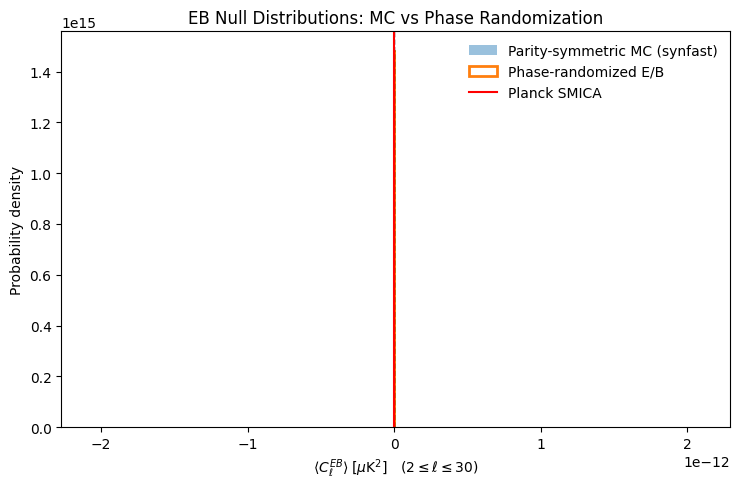

In [28]:
plt.figure(figsize=(7.5, 5))

bins = 40

plt.hist(
    EB_null_mc,
    bins=bins,
    density=True,
    histtype="stepfilled",
    alpha=0.45,
    label="Parity-symmetric MC (synfast)"
)

plt.hist(
    EB_null_phase,
    bins=bins,
    density=True,
    histtype="step",
    linewidth=2.0,
    label="Phase-randomized E/B"
)

plt.axvline(0.0, color="k", linestyle="--", linewidth=1)
plt.axvline(EB_mean, color="r", linestyle="-", label="Planck SMICA")

plt.xlabel(r"$\langle C_\ell^{EB} \rangle\;[\mu{\rm K}^2] \quad (2 \leq \ell \leq 30)$")
plt.ylabel("Probability density")
plt.title("EB Null Distributions: MC vs Phase Randomization")

plt.legend(frameon=False)
plt.tight_layout()
plt.show()


In [29]:
print(f"σ_MC / σ_phase = {sigma_null_mc / sigma_null_phase:.3f}")

σ_MC / σ_phase = 1829.228


In [30]:
# Compute Z-scores

z_scores = {k: v / sigma_null_mc for k, v in eb_estimator_results.items()}

for name, z in z_scores.items():
    print(f"{name:10s}: Z = {z:.3e}")


SMICA     : Z = -6.495e-04
NILC      : Z = -1.991e-03
SEVEM     : Z = -8.438e-04
Commander : Z = -6.788e-04


In [31]:
vals = list(eb_estimator_results.values())

mean = np.mean(vals)
scatter = np.std(vals, ddof=1)

print(f"Mean EB = {mean:.3e} μK^2")
print(f"Map-to-map RMS scatter = {scatter:.3e} μK^2")

Mean EB = -5.311e-16 μK^2
Map-to-map RMS scatter = 3.261e-16 μK^2


In [32]:
print("NumPy version:", np.__version__)
print("healpy version:", hp.__version__)
print("Random seed fixed for reproducibility.")

NumPy version: 2.0.2
healpy version: 1.19.0
Random seed fixed for reproducibility.
